<a href="https://colab.research.google.com/github/lbk209/blogger/blob/main/Hotel_reviews_Topic_Modeling_with_Llama2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📄 **Data**

In [ ]:
#see https://archive.ics.uci.edu/dataset/205/opinrank+review+dataset
#os.listdir()
!unzip sample_data/hotels.zip -d sample_data

In [ ]:
import pandas as pd
import os
import tqdm

def parse_file(file_name, hotel):
    tmp_data = []

    with open(file_name, 'rb') as f:
        for line in f:
            items = line.decode('ISO-8859-1').split('\t', maxsplit = 2)
            tmp_data.append(
                {
                    'date': items[0],
                    'title': items[1] if len(items) > 1 else '',
                    'body': items[2] if len(items) > 2 else ''
                }
            )

    tmp_df = pd.DataFrame(tmp_data)
    tmp_df['file_name'] = hotel
    return tmp_df

In [ ]:
tmp_dfs = []
data_path = 'sample_data/hotels'

for city in ['london']:
    if city.startswith('.'):
        continue
    print(city)
    for hotel in tqdm.tqdm(os.listdir(data_path + '/%s' % city)):
        file_name = data_path + '/%s/%s' % (city, hotel)
        tmp_dfs.append(parse_file(file_name, hotel))

london


100%|██████████| 875/875 [00:01<00:00, 697.27it/s]


In [ ]:
df_data = pd.concat(tmp_dfs)

## Selecting hotels

In [ ]:
def get_hotel_chain(x):
    if x.startswith('london_holiday_inn'):
        return 'Holiday Inn'
    if x.startswith('london_park_plaza'):
        return 'Park Plaza'
    if x.startswith('london_millennium'):
        return 'Millemiun'
    if x.startswith('london_park_inn'):
        return 'Park Inn'
    if x.startswith('london_hilton'):
        return 'Hilton'
    if x.startswith('london_radisson'):
        return 'Radisson'
    if x.startswith('london_travelodge'):
        return 'Travelodge'

    return 'other'

In [ ]:
for p in ['title', 'body']:
    df_data[p] = df_data[p].map(lambda x: x.strip())

df_data['country'] = df_data.file_name.map(lambda x: x.split('_', 2)[0])
df_data['city'] = df_data.file_name.map(lambda x: x.split('_', 2)[1])
df_data['full_hotel'] = df_data.file_name.map(lambda x: x.split('_', 2)[2])
df_data['hotel'] = df_data.full_hotel.map(get_hotel_chain)

In [ ]:
df_data.head()

date                                              title  \
0  Sep 25 2009                           not quite what I expected   
1  Sep 20 2009   Cheap cheerful Bad service Foreign staff Bearl...   
2  Sep 20 2009                                        Poor service   
3  Sep 11 2009                                             Awful!!   
4  Aug 21 2009                                   Very disappointed   

                                                body  \
0  very friendly welcome and qickly issued with p...   
1  This hotel was used by Newmarket coach holiday...   
2  Had booked in to Ibis Excel (booking made in F...   
3  For the money you pay there are many far bette...   
4  Extremely diappointed with the online service ...   

                                 file_name country     city  \
0  uk_england_london_ibis_london_docklands      uk  england   
1  uk_england_london_ibis_london_docklands      uk  england   
2  uk_england_london_ibis_london_docklands      uk  england   
3  uk_england_london_ibis_london_docklands      uk  england   
4  uk_england_london_ibis_london_docklands      uk  england   

                     full_hotel  hotel  
0  london_ibis_london_docklands  other  
1  london_ibis_london_docklands  other  
2  london_ibis_london_docklands  other  
3  london_ibis_london_docklands  other  
4  london_ibis_london_docklands  other

In [ ]:
df_data.groupby(['hotel'], as_index = False).aggregate({'full_hotel': ['count', 'nunique']})\
    .sort_values(('full_hotel', 'count'), ascending = False)

hotel full_hotel        
                    count nunique
7        other      66459     793
1  Holiday Inn       2844      26
0       Hilton       2671      11
6   Travelodge       2178      22
5     Radisson       2103      12
4   Park Plaza       1346       4
2    Millemiun       1209       5
3     Park Inn        539       2

In [ ]:
df_data = df_data[df_data.hotel != 'other']

In [ ]:
df_data[df_data.country == 'uk'].hotel.value_counts()

Holiday Inn    2844
Hilton         2671
Travelodge     2178
Radisson       2103
Park Plaza     1346
Millemiun      1209
Park Inn        539
Name: hotel, dtype: int64

In [ ]:
df_data.shape[0], df_data.drop_duplicates().shape[0]

(12890, 12890)

In [ ]:
df_data['id'] = list(range(df_data.shape[0]))
df_data['review'] = list(map(
    lambda x, y: '%s. %s' % (x, y),
    df_data.title,
    df_data.body
))
df_data = df_data[['id', 'hotel', 'review']]

In [ ]:
import plotly.express as px


colormap = px.colors.sequential.YlGnBu

fig = px.bar(
    df_data.groupby('hotel')[['id']].count()\
        .sort_values('id', ascending = False),
    text_auto = 'd',
    title = 'Reviews for London Hotels',
    labels = {'value': 'number of reviews'},
    width=800
)

fig.update_traces(marker_color=colormap[6], marker_line_color=colormap[6],
                  marker_line_width=1.5, opacity=0.9)

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.update_layout(showlegend = False)

## Translating comments

In [ ]:
!pip install langdetect deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.3 MB/s eta 0:00:00


In [ ]:
import langdetect
import json
from deep_translator import GoogleTranslator

def detect_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

def get_translation(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(str(text))
    except KeyboardInterrupt as e:
        raise(e)
    except:
        return '<-- ERROR -->'

In [ ]:
tmp_data = []

for rec in tqdm.tqdm(df_data.to_dict('records')):
    tmp_data.append(
        {'id': rec['id'],
        'lang': detect_language(rec['review']),
        'reviews_transl': get_translation(rec['review'])}
    )

100%|██████████| 12890/12890 [45:21<00:00,  4.74it/s]


In [ ]:
df_data = df_data.merge(pd.DataFrame(tmp_data))

In [ ]:
file = 'sample_data/hotels/raw_transl_data.csv'
df_data.to_csv(file, index = False, sep = '\t')

## Clearing not meaningful comments

*In our case, 95+% of comments are already in English.*

In [ ]:
fig = px.bar(100*df_data.lang.value_counts(normalize = True).head(10), text_auto = '.2f',
    labels = {'value': 'share of reviews, %', 'index': 'language'},
    title = 'Top reviews languages',
            width=800)

fig.update_layout(showlegend = False)

fig.update_traces(marker_color=colormap[6], marker_line_color=colormap[6],
                  marker_line_width=1.5, opacity=0.9)

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

In [ ]:
df_data['reviews_transl'] = df_data['reviews_transl'].map(lambda x: str(x).strip())
df_data['reviews_len'] = df_data.reviews_transl.map(lambda x: len(x))

*There are a lot of extremely short (and most likely not meaningful comments) — around 5% of reviews are less than 20 symbols.*

In [ ]:
fig = px.histogram(df_data, x="reviews_len",
                  nbins=250, range_x = [0, 500],
                  histnorm = 'percent',
                  labels = {'reviews_len': 'number of characters', 'percent': 'share of reviews, %'},
                  title = 'Number of characters in review',
                  width=800)

fig.update_traces(marker_color=colormap[6],
                  opacity=0.9)
fig

In [ ]:
fig = px.histogram(df_data, x="reviews_len", color = 'hotel',
                  nbins=500, range_x = [0, 1000],
                  labels = {'reviews_len': 'number of characters', 'percent': 'share of reviews, %'},
                  title = 'Number of characters in review',
                  width=800)

fig

*We can look at the most common examples to ensure that there’s not much information in such comments.*

In [ ]:
df_data.reviews_transl.map(lambda x: x.lower().strip()).value_counts().head(10)

none                          74
<-- error -->                 37
great hotel.                  11
perfect.                       8
good value for money.          7
excellent value for money.     7
excellent hotel.               7
great location.                6
very good hotel.               6
good hotel.                    5
Name: reviews_transl, dtype: int64

In [ ]:
min_len = 20
df_data[df_data.reviews_len < min_len].shape[0], df_data.shape[0]

(556, 12890)

In [ ]:
df_data[df_data.reviews_len < min_len].shape[0]/df_data.shape[0]

0.04313421256788208

So we can filter out all comments shorter than 20 symbols — 556 out of 12 890 reviews (4.3%). Then, we will analyse only long statements with more context. It’s an arbitrary threshold based on examples, you can try a couple of levels and see what texts are filtered out.


In [27]:
df_data['length_group'] = df_data.reviews_len.map(
    lambda x: '<= 20' if x < 20 else '> 20'
)

In [28]:
df_data.head()

id       hotel                                             review lang  \
0   0  Travelodge  A good budget choice but only if you can't aff...   en   
1   1  Travelodge  Wont be recommending this Travelodge.. We book...   en   
2   2  Travelodge  travelodge stay. was a great stay. loved it. t...   en   
3   3  Travelodge  It's a shame about the Noise!. The hotel was g...   en   
4   4  Travelodge  Handy for Kings Cross-nothing else. Booked thi...   en   

                                      reviews_transl  reviews_len length_group  
0  A good budget choice but only if you can't aff...          981         > 20  
1  Wont be recommending this Travelodge.. We book...          604         > 20  
2  travelodge stay. was a great stay. loved it. t...          104         > 20  
3  It's a shame about the Noise!. The hotel was g...          750         > 20  
4  Handy for Kings Cross-nothing else. Booked thi...          427         > 20

It’s worth checking whether this filter disproportionally affects some hotels. Shares of short comments are pretty close for different categories. So, the data looks OK.

In [ ]:
len_stats_df = df_data.pivot_table(index = 'hotel', values = 'id',
              columns = 'length_group', aggfunc = 'count')

len_stats_df['total'] = len_stats_df.sum(axis = 1)
len_stats_df = len_stats_df.sort_values('total', ascending = False)
px.bar(
    len_stats_df.apply(lambda x: 100.*x/len_stats_df.total).drop('total', axis = 1),
    text_auto = '.2f',
    color_discrete_map = {
          '<= 20': colormap[2],
          '> 20': colormap[5]
      }, title = "Reviews' length by hotel",
    labels = {'value': 'share of reviews, %', 'course_id': 'course',
             'length_group': 'review length'},
    width=800
)

In [ ]:
df_data2 = df_data[df_data.reviews_len > 20].drop('length_group', axis = 1)

It’s worth checking whether this filter disproportionally affects some hotels. Shares of short comments are pretty close for different categories. So, the data looks OK.

In [ ]:
df_data2.head()

id       hotel                                             review lang  \
0   0  Travelodge  A good budget choice but only if you can't aff...   en   
1   1  Travelodge  Wont be recommending this Travelodge.. We book...   en   
2   2  Travelodge  travelodge stay. was a great stay. loved it. t...   en   
3   3  Travelodge  It's a shame about the Noise!. The hotel was g...   en   
4   4  Travelodge  Handy for Kings Cross-nothing else. Booked thi...   en   

                                      reviews_transl  reviews_len  
0  A good budget choice but only if you can't aff...          981  
1  Wont be recommending this Travelodge.. We book...          604  
2  travelodge stay. was a great stay. loved it. t...          104  
3  It's a shame about the Noise!. The hotel was g...          750  
4  Handy for Kings Cross-nothing else. Booked thi...          427

In [ ]:
file = 'sample_data/hotels/hotel_reviews_with_transl.csv'
df_data2.to_csv(file, index = False, sep = '\t')

In [ ]:
!zip -j hotel_reviews_with_transl.zip {file}

  adding: hotel_reviews_with_transl.csv (deflated 80%)


### Import data

#### from local

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hotel_reviews_with_transl.zip to hotel_reviews_with_transl.zip


#### from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
file = '/content/drive/MyDrive/Colab\ Notebooks/hotel_reviews_with_transl.zip'
!cp {file} .

In [11]:
!unzip hotel_reviews_with_transl.zip -d sample_data

Archive:  hotel_reviews_with_transl.zip
  inflating: sample_data/hotel_reviews_with_transl.csv  


In [12]:
import pandas as pd

file = 'sample_data/hotel_reviews_with_transl.csv'

df_data = pd.read_csv(file, sep = '\t')
#df_data2 = pd.read_csv(file, sep = '\t')

In [13]:
df_data.head()

id       hotel                                             review lang  \
0   0  Travelodge  A good budget choice but only if you can't aff...   en   
1   1  Travelodge  Wont be recommending this Travelodge.. We book...   en   
2   2  Travelodge  travelodge stay. was a great stay. loved it. t...   en   
3   3  Travelodge  It's a shame about the Noise!. The hotel was g...   en   
4   4  Travelodge  Handy for Kings Cross-nothing else. Booked thi...   en   

                                      reviews_transl  reviews_len  
0  A good budget choice but only if you can't aff...          981  
1  Wont be recommending this Travelodge.. We book...          604  
2  travelodge stay. was a great stay. loved it. t...          104  
3  It's a shame about the Noise!. The hotel was g...          750  
4  Handy for Kings Cross-nothing else. Booked thi...          427

In [14]:
df_data.review.count()

12296

In [15]:
docs = df_data.reviews_transl.tolist()


# 🤗 HuggingFace Hub Credentials
Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:


* Create a HuggingFace account [here](https://huggingface.co)
* Apply for Llama 2 access [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)
* Get your HuggingFace token [here](https://huggingface.co/settings/tokens)

After doing so, we can login with our HuggingFace credentials so that this environment knows we have permission to download the Llama 2 model that we are interested in.

In [146]:
from huggingface_hub import notebook_login
notebook_login()

# 🦙 **Llama 2**

Now comes one of the more interesting components of this tutorial, how to load in a Llama 2 model on a T4-GPU!

We will be focusing on the `'meta-llama/Llama-2-7b-chat-hf'` variant. It is large enough to give interesting and useful results whilst small enough that it can be run on our environment.

We start by defining our model and identifying if our GPU is correctly selected. We expect the output of `device` to show a cuda device:

In [ ]:
%%capture
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

In [ ]:
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


## **Optimization & Quantizatio (generator)**

In order to load our 13 billion parameter model, we will need to perform some optimization tricks. Since we have limited VRAM and not an A100 GPU, we will need to "condense" the model a bit so that we can run it.

There are a number of tricks that we can use but the main principle is going to be 4-bit quantization.

This process reduces the 64-bit representation to only 4-bits which reduces the GPU memory that we will need. It is a recent technique and quite an elegant at that for efficient LLM loading and usage. You can find more about that method [here](https://arxiv.org/pdf/2305.14314.pdf) in the QLoRA paper and on the amazing HuggingFace blog [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [ ]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

These four parameters that we just run are incredibly important and bring many LLM applications to consumers:
* `load_in_4bit`
  * Allows us to load the model in 4-bit precision compared to the original 32-bit precision
  * This gives us an incredibly speed up and reduces memory!
* `bnb_4bit_quant_type`
  * This is the type of 4-bit precision. The paper recommends normalized float 4-bit, so that is what we are going to use!
* `bnb_4bit_use_double_quant`
  * This is a neat trick as it perform a second quantization after the first which further reduces the necessary bits
* `bnb_4bit_compute_dtype`
  * The compute type used during computation, which further speeds up the model.



Using this configuration, we can start loading in the model as well as the tokenizer:

In [ ]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

Using the model and tokenizer, we will generate a HuggingFace transformers pipeline that allows us to easily generate new text:

In [ ]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    return_full_text=False,
    temperature=0.1,
    max_new_tokens=500, # the number of tokens the model shall generate
    #repetition_penalty=1.1
    repetition_penalty=1.2
)

## **Prompt Engineering**

To check whether our model is correctly loaded, let's try it out with a few prompts.

In [ ]:
#prompt = "Could you explain to me how 4-bit quantization works as if I am 5?"
prompt = "Could you recommand hotel brands in london, uk?"

res = generator(prompt)
print(res[0]["generated_text"])

In [ ]:
prompt_repr = """<s>[INST]
    I have a topic that contains the following documents:
    - Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
    - Meat, but especially beef, is the word food in terms of emissions.
    - Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.
"""

prompt_topic = """
    The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.
"""

# topic : Environmental impacts of eating meat
prompt_q = """
    Based on the information above, please create a short label of this topic. Make sure you to only return the label and nothing more.
    [/INST]
"""

prompt = prompt_repr + prompt_topic + prompt_q
res = generator(prompt)
print(res[0]["generated_text"])


Meat Consumption and Emissions


In [ ]:
prompt = prompt_repr + prompt_q
res = generator(prompt)
print(res[0]["generated_text"])


Label: The Impact of Industrialized Meat Production on Dietary Choices


In [ ]:
prompt_q = """
    Based on the information above, please give a description of this topic in a one statement. Make sure you to only return the description and nothing more.
    [/INST]
"""

prompt = prompt_repr + prompt_topic + prompt_q
res = generator(prompt)
print(res[0]["generated_text"])

The topic of discussion revolves around the cultural shift towards meat consumption, particularly beef, and its environmental impact, as well as the personal choices and ethical considerations surrounding meat consumption.


In [ ]:
prompt = prompt_repr + prompt_q
res = generator(prompt)
print(res[0]["generated_text"])

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


The topic revolves around the shift from traditional plant-based diets to an increased reliance on industrialized meat production, highlighting both the environmental impacts of meat consumption and the moral complexities of labeling individuals based on their dietary choices.


### **Prompt Template**

We are going to keep our `system prompt` simple and to the point:

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our `user prompt` is going to the be a bit more involved. It will consist of two components, an **example** and the **main prompt**.

Let's start with the **example**. Most LLMs do a much better job of generating accurate responses if you give them an example to work with. We will show it an accurate example of the kind of output we are expecting.

In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

This example, based on a number of keywords and documents primarily about the impact of
meat, helps to model to understand the kind of output it should give. We show the model that we were expecting only the label, which is easier for us to extract.

Next, we will create a template that we can use within BERTopic:

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [ ]:
prompt = system_prompt + example_prompt + main_prompt
print(prompt)


<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>

I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat

[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information

In [ ]:
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please give a description of this topic in a one statement. Make sure you to only return the description and nothing more.
[/INST]
"""

prompt_desc = system_prompt + example_prompt + main_prompt
print(prompt_desc)


<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>

I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat

[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information

# 🗨️ **BERTopic**

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [ ]:
#docs = df_data.reviews_transl.tolist()

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
#st_id = "BAAI/bge-small-en" # Recommend switching to newest BAAI/bge-small-en-v1.5
#st_id = 'BAAI/bge-small-en-v1.5'
st_id = 'all-MiniLM-L6-v2' # mapping sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

embedding_model = SentenceTransformer(st_id)

embeddings = embedding_model.encode(docs, show_progress_bar=True)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/385 [00:00<?, ?it/s]

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

# dimensionality reduction
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine', random_state=42)

# clustering algorithm
hdbscan_model = HDBSCAN(
    # a lower min_cluster_size will generate more topics
    min_cluster_size=30,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
    )

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [ ]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)
llama2desc = TextGeneration(generator, prompt=prompt_desc)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "Llama2Desc": llama2desc,
    "MMR": mmr,
}

In [ ]:
# for fast training to assess the number of topics
representation_model = keybert

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True,

  # Calculate the probabilities of all topics per document instead of the probability of the assigned topic per document.
  # This could slow down the extraction of topics if you have many documents (> 100_000).
  #calculate_probabilities=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-01-22 07:20:49,359 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-22 07:21:07,552 - BERTopic - Dimensionality - Completed ✓
2024-01-22 07:21:07,555 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-22 07:21:08,727 - BERTopic - Cluster - Completed ✓
2024-01-22 07:21:08,748 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 47/47 [13:37<00:00, 17.40s/it]
2024-01-22 07:46:39,602 - BERTopic - Representation - Completed ✓


In [ ]:
len(topic_model.get_topics()) - 1

46

In [ ]:
# Show topics
topic_model.get_topic_info().head(7)

Topic  Count                           Name  \
0     -1   7227              -1_the_and_to_was   
1      0    541         0_hotel_very_and_great   
2      1    359  1_london_hotel_great_location   
3      2    284       2_victoria_plaza_the_and   
4      3    230   3_paddington_heathrow_the_to   
5      4    225        4_gloucester_the_and_is   
6      5    193          5_noise_the_noisy_was   

                                      Representation  \
0    [the, and, to, was, in, we, for, of, it, hotel]   
1  [hotel, very, and, great, was, good, location,...   
2  [london, hotel, great, location, and, in, the,...   
3  [victoria, plaza, the, and, hotel, station, to...   
4  [paddington, heathrow, the, to, and, station, ...   
5  [gloucester, the, and, is, hotel, was, in, tub...   
6  [noise, the, noisy, was, room, to, of, and, in...   

                                             KeyBERT  \
0  [rooms, hotel, room, bathroom, bed, booked, lo...   
1  [hotel, rooms, restaurant, place, spacious, ro...   
2  [hotels, hotel, london, rooms, place, room, re...   
3  [hotel, hotels, london, gatwick, palace, rooms...   
4  [paddington, heathrow, london, hotel, rooms, h...   
5  [gloucester, hotel, rooms, inn, london, room, ...   
6  [rooms, hotel, room, noise, noisy, bed, recept...   

                                              Llama2  \
0                     [Travelodge, , , , , , , , , ]   
1          [Central London Hotels, , , , , , , , , ]   
2            [London Hotel Review, , , , , , , , , ]   
3                   [Hotel Review, , , , , , , , , ]   
4  [Convenient Hotels Near Paddington Station, , ...   
5                 [Hotel Location, , , , , , , , , ]   
6         [Noisy Hotel Experience, , , , , , , , , ]   

                                          Llama2Desc  \
0  [Travelodge hotels, specifically those located...   
1  [This topic revolves around positive reviews o...   
2  [A luxurious and conveniently located hotel of...   
3  [Stays at the Victoria Park Plaza Hotel in Lon...   
4  [Conveniently located near Paddington Station,...   
5  [Stayed at the Millennium Gloucester hotel in ...   
6  [Noisy environment with various distractions, ...   

                                                 MMR  \
0    [the, and, to, was, in, we, for, of, it, hotel]   
1  [hotel, very, and, great, was, good, location,...   
2  [london, hotel, great, location, and, in, the,...   
3  [victoria, plaza, the, and, hotel, station, to...   
4  [paddington, heathrow, the, to, and, station, ...   
5  [gloucester, the, and, is, hotel, was, in, tub...   
6  [noise, the, noisy, was, room, to, of, and, in...   

                                 Representative_Docs  
0  [Good for wheelchair users. We stayed here for...  
1  [Good location very nice hotel.. The hotels lo...  
2  [Great hotel. Very nice modern hotel with nice...  
3  [Good location nice large rooms - but nothing ...  
4  [Convenient Hilton with Good Size Rooms. We ju...  
5  [Excellent location. I stayed at the Millenniu...  
6  [good location rather expensive. We're just ba...

In [ ]:
titles = [x[:100] for x in docs]
topics_to_visualize = range(20)

topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, hide_document_hover=False,
                                topics=topics_to_visualize,
                                #custom_labels=True
                                )

In [ ]:
# set `calculate_probabilities` to True as it uses the topic probabilities of all topics
topic_model.visualize_distribution(probs[0])

ValueError: This visualization cannot be used if you have set `calculate_probabilities` to False as it uses the topic probabilities of all topics. 

### Save model

In [ ]:
x = "sentence-transformers/all-MiniLM-L6-v2"
d = 'sample_data/tm_hotel_reviews'

topic_model.save(d, serialization="safetensors", save_embedding_model=x, save_ctfidf=True)

In [ ]:
import pickle

#Store sentences & embeddings on disc
f = 'sample_data/reduced_embeddings.pkl'

with open(f, "wb") as fOut:
    pickle.dump(reduced_embeddings, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle

#Store sentences & embeddings on disc
f = 'sample_data/tm_hotel_reviews_attrs.pkl'

with open(f, "wb") as fOut:
    obj = {'reduced_embeddings': reduced_embeddings,
           'representative_docs_': topic_model.representative_docs_
           }
    pickle.dump(obj, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

zfile = '/content/drive/MyDrive/Colab\ Notebooks/tm_hotel_reviews_2.zip'
!zip -r {zfile} {d} {f}

  adding: sample_data/tm_hotel_reviews_2/ (stored 0%)
  adding: sample_data/tm_hotel_reviews_2/ctfidf.safetensors (deflated 85%)
  adding: sample_data/tm_hotel_reviews_2/topics.json (deflated 86%)
  adding: sample_data/tm_hotel_reviews_2/config.json (deflated 42%)
  adding: sample_data/tm_hotel_reviews_2/topic_embeddings.safetensors (deflated 7%)
  adding: sample_data/tm_hotel_reviews_2/ctfidf_config.json (deflated 71%)
  adding: sample_data/tm_hotel_reviews_attrs.pkl (deflated 49%)


### Load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#zfile = '/content/drive/MyDrive/Colab\ Notebooks/tm_hotel_reviews.zip'
zfile = '/content/drive/MyDrive/Colab\ Notebooks/tm_hotel_reviews_2.zip'
!cp {zfile} .

In [3]:
!unzip -l tm_hotel_reviews_2.zip

Archive:  tm_hotel_reviews_2.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2024-01-22 09:24   sample_data/tm_hotel_reviews_2/
 30133792  2024-01-22 09:24   sample_data/tm_hotel_reviews_2/ctfidf.safetensors
   254593  2024-01-22 09:24   sample_data/tm_hotel_reviews_2/topics.json
      359  2024-01-22 09:24   sample_data/tm_hotel_reviews_2/config.json
    72280  2024-01-22 09:24   sample_data/tm_hotel_reviews_2/topic_embeddings.safetensors
 46673703  2024-01-22 09:24   sample_data/tm_hotel_reviews_2/ctfidf_config.json
   379780  2024-01-22 09:29   sample_data/tm_hotel_reviews_attrs.pkl
---------                     -------
 77514507                     7 files


In [4]:
!unzip {zfile}

Archive:  /content/drive/MyDrive/Colab Notebooks/tm_hotel_reviews_2.zip
   creating: sample_data/tm_hotel_reviews_2/
  inflating: sample_data/tm_hotel_reviews_2/ctfidf.safetensors  
  inflating: sample_data/tm_hotel_reviews_2/topics.json  
  inflating: sample_data/tm_hotel_reviews_2/config.json  
  inflating: sample_data/tm_hotel_reviews_2/topic_embeddings.safetensors  
  inflating: sample_data/tm_hotel_reviews_2/ctfidf_config.json  
  inflating: sample_data/tm_hotel_reviews_attrs.pkl  


In [5]:
%%capture
!pip install bertopic

In [6]:
from bertopic import BERTopic

#d = 'sample_data/tm_hotel_reviews'
d = 'sample_data/tm_hotel_reviews_2'

topic_model = BERTopic.load(d)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [7]:
import pickle

#Load sentences & embeddings from disc
#f = 'sample_data/reduced_embeddings.pkl'
f = 'sample_data/tm_hotel_reviews_attrs.pkl'

with open(f, "rb") as fIn:
    obj = pickle.load(fIn)
    reduced_embeddings = obj['reduced_embeddings']
    topic_model.representative_docs_ = obj['representative_docs_']

In [8]:
topic_model.get_topic_info().head(7)

Topic  Count                                              Name  \
0     -1   7227                         -1_hotel_room_good_london   
1      0    541                       0_hotel_great_good_location   
2      1    359                     1_london_hotel_great_location   
3      2    284      2_victoria_plaza_victoria station_park plaza   
4      3    230  3_paddington_heathrow_station_paddington station   
5      4    225                      4_gloucester_hotel_room_tube   
6      5    193                          5_noise_room_noisy_hotel   

                                  CustomName  \
0                                 Travelodge   
1                      Central London Hotels   
2                        London Hotel Review   
3                               Hotel Review   
4  Convenient Hotels Near Paddington Station   
5                             Hotel Location   
6                     Noisy Hotel Experience   

                                      Representation  \
0  [hotel, room, good, london, breakfast, staff, ...   
1  [hotel, great, good, location, staff, stay, ni...   
2  [london, hotel, great, location, stay, good, s...   
3  [victoria, plaza, victoria station, park plaza...   
4  [paddington, heathrow, station, paddington sta...   
5  [gloucester, hotel, room, tube, gloucester roa...   
6  [noise, room, noisy, hotel, night, sleep, floo...   

                                             KeyBERT  \
0  [rooms, hotel, room, bathroom, bed, booked, lo...   
1  [hotel, rooms, restaurant, place, spacious, ro...   
2  [hotels, hotel, london, rooms, place, room, re...   
3  [hotel, hotels, london, gatwick, palace, rooms...   
4  [paddington, heathrow, london, hotel, rooms, h...   
5  [gloucester, hotel, rooms, inn, london, room, ...   
6  [rooms, hotel, room, noise, noisy, bed, recept...   

                                              Llama2  \
0                     [Travelodge, , , , , , , , , ]   
1          [Central London Hotels, , , , , , , , , ]   
2            [London Hotel Review, , , , , , , , , ]   
3                   [Hotel Review, , , , , , , , , ]   
4  [Convenient Hotels Near Paddington Station, , ...   
5                 [Hotel Location, , , , , , , , , ]   
6         [Noisy Hotel Experience, , , , , , , , , ]   

                                          Llama2Desc  \
0  [Travelodge hotels, specifically those located...   
1  [This topic revolves around positive reviews o...   
2  [A luxurious and conveniently located hotel of...   
3  [Stays at the Victoria Park Plaza Hotel in Lon...   
4  [Conveniently located near Paddington Station,...   
5  [Stayed at the Millennium Gloucester hotel in ...   
6  [Noisy environment with various distractions, ...   

                                                 MMR  \
0    [the, and, to, was, in, we, for, of, it, hotel]   
1  [hotel, very, and, great, was, good, location,...   
2  [london, hotel, great, location, and, in, the,...   
3  [victoria, plaza, the, and, hotel, station, to...   
4  [paddington, heathrow, the, to, and, station, ...   
5  [gloucester, the, and, is, hotel, was, in, tub...   
6  [noise, the, noisy, was, room, to, of, and, in...   

                                 Representative_Docs  
0  [Good for wheelchair users. We stayed here for...  
1  [Good location very nice hotel.. The hotels lo...  
2  [Great hotel. Very nice modern hotel with nice...  
3  [Good location nice large rooms - but nothing ...  
4  [Convenient Hilton with Good Size Rooms. We ju...  
5  [Excellent location. I stayed at the Millenniu...  
6  [good location rather expensive. We're just ba...

In [16]:
custom_labels = True
topics_to_visualize = range(20)

titles = [x[:100] for x in docs]
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, hide_document_hover=False,
                                topics=topics_to_visualize,
                                custom_labels=custom_labels
                                )

# 💦 **Post-processing**

In [ ]:
def print_with_line_feed(input_string, line_length=50):
    words = input_string.split()
    current_line_length = 0

    for word in words:
        if current_line_length + len(word) <= line_length:
            print(word, end=" ")
            current_line_length += len(word) + 1  # +1 for the space
        else:
            print()  # Start a new line
            print(word, end=" ")
            current_line_length = len(word) + 1

    print()  # Ensure the last line is printed

# Example usage
your_string = "This is a sample string that you want to print with line feed every 50 characters. This string is just for demonstration purposes."
print_with_line_feed(your_string)

This is a sample string that you want to print 
with line feed every 50 characters. This string is 
just for demonstration purposes. 


## Vectorizer
Pass the CountVectorizer after training where llm used full context in training

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Fine-tune topic representations after training BERTopic
# you can pass the CountVectorizer before and after training your topic model.
# Passing it before training allows you to minimize the size of the resulting c-TF-IDF matrix
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3),
                                   #min_df=10
                                   )
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [ ]:
topic_model.get_topic_info().head(10)

Topic  Count                                              Name  \
0     -1   7227                         -1_hotel_room_good_london   
1      0    541                       0_hotel_great_good_location   
2      1    359                     1_london_hotel_great_location   
3      2    284      2_victoria_plaza_victoria station_park plaza   
4      3    230  3_paddington_heathrow_station_paddington station   
5      4    225                      4_gloucester_hotel_room_tube   
6      5    193                          5_noise_room_noisy_hotel   
7      6    191     6_radisson_hotel_edwardian_radisson edwardian   
8      7    162                      7_hilton_london_hotel_bridge   
9      8    147            8_covent_covent garden_garden_location   

                                      Representation  \
0  [hotel, room, good, london, breakfast, staff, ...   
1  [hotel, great, good, location, staff, stay, ni...   
2  [london, hotel, great, location, stay, good, s...   
3  [victoria, plaza, victoria station, park plaza...   
4  [paddington, heathrow, station, paddington sta...   
5  [gloucester, hotel, room, tube, gloucester roa...   
6  [noise, room, noisy, hotel, night, sleep, floo...   
7  [radisson, hotel, edwardian, radisson edwardia...   
8  [hilton, london, hotel, bridge, room, tower, g...   
9  [covent, covent garden, garden, location, trav...   

                                             KeyBERT  \
0  [rooms, hotel, room, bathroom, bed, booked, lo...   
1  [hotel, rooms, restaurant, place, spacious, ro...   
2  [hotels, hotel, london, rooms, place, room, re...   
3  [hotel, hotels, london, gatwick, palace, rooms...   
4  [paddington, heathrow, london, hotel, rooms, h...   
5  [gloucester, hotel, rooms, inn, london, room, ...   
6  [rooms, hotel, room, noise, noisy, bed, recept...   
7  [hotels, hotel, rooms, room, london, covent, r...   
8  [hotel, hotels, hilton, hiltons, london, rooms...   
9  [covent, london, hotel, rooms, travelodge, boo...   

                                              Llama2  \
0                     [Travelodge, , , , , , , , , ]   
1          [Central London Hotels, , , , , , , , , ]   
2            [London Hotel Review, , , , , , , , , ]   
3                   [Hotel Review, , , , , , , , , ]   
4  [Convenient Hotels Near Paddington Station, , ...   
5                 [Hotel Location, , , , , , , , , ]   
6         [Noisy Hotel Experience, , , , , , , , , ]   
7                [Radisson Hotels, , , , , , , , , ]   
8         [Modern Hotel in London, , , , , , , , , ]   
9  [Great Location for Budget Accommodation, , , ...   

                                          Llama2Desc  \
0  [Travelodge hotels, specifically those located...   
1  [This topic revolves around positive reviews o...   
2  [A luxurious and conveniently located hotel of...   
3  [Stays at the Victoria Park Plaza Hotel in Lon...   
4  [Conveniently located near Paddington Station,...   
5  [Stayed at the Millennium Gloucester hotel in ...   
6  [Noisy environment with various distractions, ...   
7  [Staying at the Radisson Edwardian hotels in L...   
8  [Stays at the Hilton London Tower Bridge hotel...   
9  [Great location for a budget-friendly stay in ...   

                                                 MMR  Representative_Docs  
0    [the, and, to, was, in, we, for, of, it, hotel]                  NaN  
1  [hotel, very, and, great, was, good, location,...                  NaN  
2  [london, hotel, great, location, and, in, the,...                  NaN  
3  [victoria, plaza, the, and, hotel, station, to...                  NaN  
4  [paddington, heathrow, the, to, and, station, ...                  NaN  
5  [gloucester, the, and, is, hotel, was, in, tub...                  NaN  
6  [noise, the, noisy, was, room, to, of, and, in...                  NaN  
7  [radisson, the, edwardian, hotel, and, in, to,...                  NaN  
8  [hilton, the, and, of, london, is, to, in, was...                  NaN  
9  [covent, gar

In [ ]:
num = 10
line_length = 100
cols = ['Topic', 'Count', 'Llama2', 'Llama2Desc']

for _, r in topic_model.get_topic_info().loc[1:, cols].head(num).iterrows():
    print(f'Topic {r[0]}, Count {r[1]}: {r[2][0]}')
    print_with_line_feed(r[3][0], line_length)
    #print('-'*line_length)
    print()

Topic 0, Count 541: Central London Hotels
This topic revolves around positive reviews of various hotels, highlighting their good locations, 
comfortable rooms, helpful staff, and overall quality of experience. 

Topic 1, Count 359: London Hotel Review
A luxurious and conveniently located hotel offering comfortable accommodations, friendly staff, and 
modern amenities in central London. 

Topic 2, Count 284: Hotel Review
Stays at the Victoria Park Plaza Hotel in London 

Topic 3, Count 230: Convenient Hotels Near Paddington Station
Conveniently located near Paddington Station, these hotels offer easy access to Heathrow Airport via 
the Heathrow Express, with some options offering direct views into the station and spacious, modern 
rooms with amenities such as executive lounges, free internet, and comfortable beds. 

Topic 4, Count 225: Hotel Location
Stayed at the Millennium Gloucester hotel in London, located near Gloucester Road tube station, with 
good access to various attractions v

In [ ]:
tid = 9

for s in topic_model.representative_docs_[tid]:
    #prompt = f"summarize a following in one sentence: {s}"
    prompt = f"summarize: {s}"
    res = generator(prompt)
    print(res[0]["generated_text"])
    print('- - '*50)

KeyError: 9

In [ ]:
tid = 9

for s in topic_model.representative_docs_[tid]:
    print_with_line_feed(s, 100)
    print()

Great Location Small Rooms. I recently had a 4 night stay at the Millenium Mayfair with my wife. It 
was a getaway for some London sightseeing, and after searching the web at length, the Mayfair appear
ed to offer the best value proposition for us wanting to stay in the Mayfair section of London.The h
otel is somewhat small, sitting on Grovsener Park in the heart of Mayfair. Its pretty much equidista
nt to Oxford Street, New Bond Street, and Piccadelly St., and is in a very upscale quiet part of tow
n. To me, this is the perfect location - everything I needed was a short walk away.The lobby is clea
n and sharp. The porters scamper over to you if you walk a few meters from your luggage, I guess the
re is a fear of people dashing in and out with your things. Our clerk was a bit new, and to our dism
ay nobody was really willing to help him as he struggled through our check-in. He made a number of m
istakes, many of which were never rectified, but it didn't detract noticeably from our stay

## Outlier reduction

In [ ]:
# Use the "c-TF-IDF" strategy with a threshold
# threshold is the minimum similarity.
new_topics = topic_model.reduce_outliers(docs, topics , strategy="c-tf-idf", threshold=0.1)

# count outliers
len([x for x in new_topics if x < 0])

6455

In [ ]:
t = topics
#t = new_topics

new_topics = topic_model.reduce_outliers(docs, t , strategy="distributions", threshold=0.5)

# count outliers
len([x for x in new_topics if x < 0])

100%|██████████| 7/7 [00:22<00:00,  3.25s/it]


6231

In [ ]:
t = topics
#t = new_topics
new_topics = topic_model.reduce_outliers(docs, t, strategy="embeddings", threshold=0.5)

# count outliers
len([x for x in new_topics if x < 0])

1988

In [ ]:
t = topics
#t = new_topics

# the threshold is minimum probability when strategy="probabilities"
new_topics = topic_model.reduce_outliers(docs, t, strategy="probabilities", probabilities=probs, threshold=0.05)

# count outliers
len([x for x in new_topics if x < 0])

6678

### update with new_topics

In [ ]:
topic_model.update_topics(docs, topics=new_topics)

2024-01-22 01:08:32,468 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
titles = [x[:100] for x in docs]
topics_to_visualize = range(20)

topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings,
                                hide_annotations=True, hide_document_hover=False,
                                topics=topics_to_visualize,
                                #custom_labels=True
                                )

Now that we are done training our model, let's see what topics were generated:

In [ ]:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Name', 'Representation'] + extra_cols]

extra_cols = ['Llama2', 'Llama2Desc']
#extra_cols = []
get_topic_stats(topic_model, extra_cols).head(10).set_index('Topic')

Count      Share  CumulativeShare  \
Topic                                      
-1      7227  58.775211        58.775211   
 0       541   4.399805        63.175016   
 1       359   2.919649        66.094665   
 2       284   2.309694        68.404359   
 3       230   1.870527        70.274886   
 4       225   1.829863        72.104750   
 5       193   1.569616        73.674366   
 6       191   1.553351        75.227716   
 7       162   1.317502        76.545218   
 8       147   1.195511        77.740729   

                                                   Name  \
Topic                                                     
-1                            -1_hotel_room_good_london   
 0                          0_hotel_great_good_location   
 1                        1_london_hotel_great_location   
 2         2_victoria_plaza_victoria station_park plaza   
 3     3_paddington_heathrow_station_paddington station   
 4                         4_gloucester_hotel_room_tube   
 5                             5_noise_room_noisy_hotel   
 6        6_radisson_hotel_edwardian_radisson edwardian   
 7                         7_hilton_london_hotel_bridge   
 8               8_covent_covent garden_garden_location   

                                          Representation  \
Topic                                                      
-1     [hotel, room, good, london, breakfast, staff, ...   
 0     [hotel, great, good, location, staff, stay, ni...   
 1     [london, hotel, great, location, stay, good, s...   
 2     [victoria, plaza, victoria station, park plaza...   
 3     [paddington, heathrow, station, paddington sta...   
 4     [gloucester, hotel, room, tube, gloucester roa...   
 5     [noise, room, noisy, hotel, night, sleep, floo...   
 6     [radisson, hotel, edwardian, radisson edwardia...   
 7     [hilton, london, hotel, bridge, room, tower, g...   
 8     [covent, covent garden, garden, location, trav...   

                                                  Llama2  \
Topic                                                      
-1                        [Travelodge, , , , , , , , , ]   
 0             [Central London Hotels, , , , , , , , , ]   
 1               [London Hotel Review, , , , , , , , , ]   
 2                      [Hotel Review, , , , , , , , , ]   
 3     [Convenient Hotels Near Paddington Station, , ...   
 4                    [Hotel Location, , , , , , , , , ]   
 5            [Noisy Hotel Experience, , , , , , , , , ]   
 6                   [Radisson Hotels, , , , , , , , , ]   
 7            [Modern Hotel in London, , , , , , , , , ]   
 8     [Great Location for Budget Accommodation, , , ...   

                                              Llama2Desc  
Topic                                                     
-1     [Travelodge hotels, specifically those located...  
 0     [This topic revolves around positive reviews o...  
 1     [A luxurious and conveniently located hotel of...  
 2     [Stays at the Victoria Park Plaza Hotel in Lon...  
 3     [Conveniently located near Paddington Station,...  
 4     [Stayed at the Millennium Gloucester hotel in ...  
 5     [Noisy environment with various distractions, ...  
 6     [Staying at the Radisson Edwardian hotels in L...  
 7     [Stays at the Hilton London Tower Bridge hotel...  
 8     [Great location for a budget-friendly stay in ...

In [ ]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]

# no outlier after the reduction using the embeddings of each outlier documents
#llama2_labels = llama2_labels[1:]

topic_model.set_topic_labels(llama2_labels)

In [ ]:
topic_model.custom_labels_[:7]

['Positive Hotel Review',
 'Hotel Reviews',
 'Convenient location for Heathrow travel',
 'Great London Hotel Experience',
 'Millennium Gloucester Hotel',
 'Modern Hotel near London Tower',
 'Hotel Near Oxford Street']

In [ ]:
topic_model.get_topic(0, full=True)

{'Main': [('hotel', 0.018875981778046134),
  ('great', 0.01531460861462208),
  ('good', 0.014479102774571699),
  ('location', 0.014289397128127886),
  ('staff', 0.013959327700403073),
  ('stay', 0.011914147744939057),
  ('nice', 0.011136980973372202),
  ('room', 0.011108570191760054),
  ('excellent', 0.010110510391340666),
  ('breakfast', 0.009338822971771164)],
 'KeyBERT': [('hotel', 0.63202846),
  ('rooms', 0.44081992),
  ('restaurant', 0.40975654),
  ('place', 0.36457223),
  ('spacious', 0.32150376),
  ('room', 0.32137206),
  ('pleasant', 0.31699654),
  ('location', 0.300309),
  ('station', 0.28432736),
  ('comfortable', 0.2637873)],
 'Llama2': [('Central London Hotels', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0)],
 'Llama2Desc': [('This topic revolves around positive reviews of various hotels, highlighting their good locations, comfortable rooms, helpful staff, and overall quality of experience.',
   1),
  ('', 0),
  ('', 0

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [ ]:
titles = [x[:100] for x in docs]
topics_to_visualize = range(20)

topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings,
                                topics=topics_to_visualize,
                                hide_annotations=True, hide_document_hover=False, custom_labels=True)

In [ ]:
topic_model.visualize_barchart(top_n_topics = 8,
                               n_words = 10,
                               custom_labels=True,
                               height=300)

In [ ]:
topic_model.visualize_topics(custom_labels=True)

In [ ]:
topic_model.visualize_heatmap(
    n_clusters = 30,
    custom_labels=True
    )

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_))

dist_df = pd.DataFrame(distance_matrix, columns=topic_model.topic_labels_.values(),
                       index=topic_model.topic_labels_.values())

tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index':
            continue
        tmp.append(
            {
                'topic1': t1,
                'topic2': t2,
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(lambda x: not x.startswith('-1'))) &
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]

pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]

In [ ]:
pair_dist_df.sort_values('distance', ascending = False).head(10)

topic1  \
92        0_hotel_great_good_location   
985         19_hotel_room_london_good   
49        0_hotel_great_good_location   
67        0_hotel_great_good_location   
942         19_hotel_room_london_good   
1123  22_value_money_good_value money   
619         12_hilton_room_hotel_quot   
1124  22_value_money_good_value money   
725     14_room_shower_bathroom_hotel   
948         19_hotel_room_london_good   

                                           topic2  distance  
92                   44_hotel_breakfast_room_good  0.952116  
985                  44_hotel_breakfast_room_good  0.950375  
49                  1_london_hotel_great_location  0.939430  
67                      19_hotel_room_london_good  0.937025  
942                 1_london_hotel_great_location  0.926166  
1123                   41_london_value_good_hotel  0.914226  
619                  7_hilton_london_hotel_bridge  0.913839  
1124  42_value money_value_money_good value money  0.896171  
725                     19_hotel_room_london_good  0.893993  
948                  7_hilton_london_hotel_bridge  0.883323

# Topic Distributions
If using calculate_probabilities=True is not possible, then you can approximate the topic-document distributions using .approximate_distribution. It is a fast and flexible method for creating different topic-document distributions.

In [ ]:
# If using calculate_probabilities=True
#topic_distr = probs

# If using calculate_probabilities=True is not possible
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, window = 4, calculate_tokens=True)

100%|██████████| 13/13 [00:50<00:00,  3.89s/it]


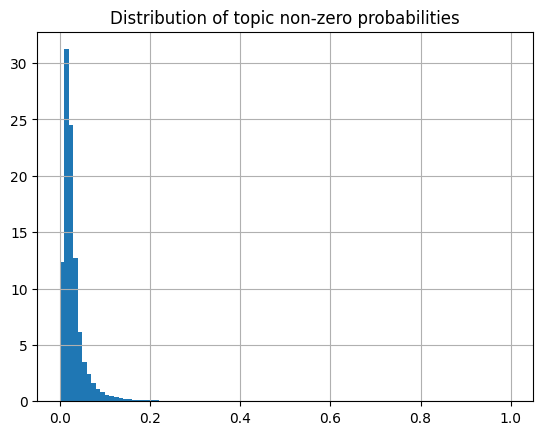

In [ ]:
raw_distr = pd.Series(topic_distr.ravel())
raw_distr = raw_distr[raw_distr > 0]

ax = raw_distr.hist(bins = 100, range = [0, 1],
                                        weights = np.ones_like(raw_distr)*100/raw_distr.shape[0])
_ = ax.set_title('Distribution of topic non-zero probabilities')

In [ ]:
threshold = 0.05

df_data['max_topic_distr'] = topic_distr.max(axis = 1)
1 - df_data[df_data.max_topic_distr > threshold].shape[0]/df_data.shape[0]

0.03968770331815219

In [ ]:
topic_distr[3].max()

0.1767973116664461

In [ ]:
df = df_data.reset_index(drop=True)
df_data[(df_data.max_topic_distr > threshold) & (df_data.reviews_len <= 100)].sample(10)

id        hotel                                             review  \
3076    3206  Holiday Inn                            Très pratique pour O2.    
8185    8551       Hilton                           Nice but not very nice.    
8769    9164   Travelodge                           Better value elsewhere.    
3519    3667  Holiday Inn                Great place to stay with a family.    
7067    7380       Hilton              Great value - will stay here again!.    
9011    9432  Holiday Inn                 Location and Great for the Price.    
4316    4505   Park Plaza  Superb value at the moment - some teething pro...   
12283  12875  Holiday Inn  Tolles Preis-Leistung-Verhältnis etwas ausserh...   
4955    5177       Hilton                     Good Option for North London.    
11737  12278     Park Inn                             Loved the Bonnington.    

      lang                                     reviews_transl  reviews_len  \
3076    fr                             Very practical for O2.           22   
8185    en                            Nice but not very nice.           23   
8769    no                            Better value elsewhere.           23   
3519    en                 Great place to stay with a family.           34   
7067    en               Great value - will stay here again!.           36   
9011    en                  Location and Great for the Price.           33   
4316    en  Superb value at the moment - some teething pro...           52   
12283   de     Great value for money a little out of the way.           46   
4955    en                      Good Option for North London.           29   
11737   en                              Loved the Bonnington.           21   

       max_topic_distr  
3076          1.000000  
8185          0.551375  
8769          0.594346  
3519          0.684311  
7067          0.248332  
9011          0.132861  
4316          0.744681  
12283         0.567748  
4955          1.000000  
11737         1.000000

In [ ]:
doc_id = 3667

In [ ]:
x = 0.05
topic_model.visualize_distribution(topic_distr[doc_id], min_probability=x, custom_labels=True)

In [ ]:
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])

In [ ]:
import tqdm

tmp_dfs = []

for thr in tqdm.tqdm(np.arange(0, 0.15, 0.001)):
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1

    tmp_df['num_topics_group'] = tmp_df['num_topics']\
        .map(lambda x: str(x) if x < 5 else '5+')

    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr

    tmp_dfs.append(tmp_df_aggr)

100%|██████████| 150/150 [00:29<00:00,  5.02it/s]


In [ ]:
num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

In [ ]:
num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

In [ ]:
import plotly.express as px

colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df,
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics',
                'value': 'share of reviews, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      },
        width = 800
       )

## Comparing distributions by hotels

In [ ]:
threshold = 0.06

In [ ]:
df_data['multiple_topics'] = list(map(
    lambda doc_topic_distr: list(map(
        lambda y: y[0], filter(lambda x: x[1] >= threshold,
                               (enumerate(doc_topic_distr)))
    )), topic_distr
))

In [ ]:
tmp_data = []

for rec in df_data.to_dict('records'):
    if len(rec['multiple_topics']) != 0:
        mult_topics = rec['multiple_topics']
    else:
        mult_topics = [-1]

    for topic in mult_topics:
        tmp_data.append(
            {
                'topic': topic, # topic id
                'id': rec['id'], # doc id
                'hotel': rec['hotel'],
                'reviews_transl': rec['reviews_transl']
            }
        )


mult_topics_df = pd.DataFrame(tmp_data)

In [ ]:
tmp_data = []

for hotel in mult_topics_df.hotel.unique():
    for topic in mult_topics_df.topic.unique():
        tmp_data.append({
            'hotel': hotel,
            'topic_id': topic,
            'total_hotel_reviews': mult_topics_df[mult_topics_df.hotel == hotel].id.nunique(),
            'topic_hotel_reviews': mult_topics_df[(mult_topics_df.hotel == hotel)
                                                  & (mult_topics_df.topic == topic)].id.nunique(),
            'other_hotels_reviews': mult_topics_df[mult_topics_df.hotel != hotel].id.nunique(),
            'topic_other_hotels_reviews': mult_topics_df[(mult_topics_df.hotel != hotel)
                                                  & (mult_topics_df.topic == topic)].id.nunique()
        })

mult_topics_stats_df = pd.DataFrame(tmp_data)
mult_topics_stats_df['topic_hotel_share'] = 100*mult_topics_stats_df.topic_hotel_reviews/mult_topics_stats_df.total_hotel_reviews
mult_topics_stats_df['topic_other_hotels_share'] = 100*mult_topics_stats_df.topic_other_hotels_reviews/mult_topics_stats_df.other_hotels_reviews

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

mult_topics_stats_df['difference_pval'] = list(map(
    lambda x1, x2, n1, n2: proportions_ztest(
        count = [x1, x2],
        nobs = [n1, n2],
        alternative = 'two-sided'
    )[1],
    mult_topics_stats_df.topic_other_hotels_reviews,
    mult_topics_stats_df.topic_hotel_reviews,
    mult_topics_stats_df.other_hotels_reviews,
    mult_topics_stats_df.total_hotel_reviews
))

In [ ]:
mult_topics_stats_df['sign_difference'] = mult_topics_stats_df.difference_pval.map(
    lambda x: 1 if x <= threshold else 0
)

def relative_actuality(d, sign):
    sign_percent = 1
    if sign == 0:
        return 'no diff'
    if (d >= -sign_percent) and (d <= sign_percent):
        return 'no diff'
    if d < -sign_percent:
        return 'lower'
    if d > sign_percent:
        return 'higher'

mult_topics_stats_df['diff_significance_total'] = list(map(
    relative_actuality,
    mult_topics_stats_df.topic_hotel_share - mult_topics_stats_df.topic_other_hotels_share,
    mult_topics_stats_df.sign_difference
))

In [ ]:
import plotly

def get_start(topic_model):
    if min(topic_model.topics_) < 0:
        return 1
    else:
        return 0


def get_topic_representation(topic_model, topic, custom_labels=False):
    if custom_labels:
        return topic_model.custom_labels_[topic + get_start(topic_model)]
    else:
        data = topic_model.get_topic(topic)
        return ', '.join(list(map(lambda x: x[0], data)))


def get_topic_representation_title(topic_model, topic, custom_labels=False):
    if custom_labels:
        return topic_model.custom_labels_[topic + get_start(topic_model)]
    else:
        data = topic_model.get_topic(topic)
        data = list(map(lambda x: x[0], data))

        return ', '.join(data[:5]) + ', <br>         ' + ', '.join(data[5:])


def get_color_sign(rel):
    if rel == 'no diff':
        return plotly.colors.qualitative.Set2[7]
    if rel == 'lower':
        return plotly.colors.qualitative.Set2[1]
    if rel == 'higher':
        return plotly.colors.qualitative.Set2[0]


def get_graphs_for_topic(t, fsize=(600,400), custom_labels=False):
    topic_stats_df = mult_topics_stats_df[mult_topics_stats_df.topic_id == t]\
        .sort_values('total_hotel_reviews', ascending = False).set_index('hotel')


    colors = list(map(
        get_color_sign,
        topic_stats_df.diff_significance_total
    ))


    fig = px.bar(topic_stats_df.reset_index(), x = 'hotel', y = 'topic_hotel_share',
                title = 'Topic_%s: %s' % (t, get_topic_representation_title(topic_model,
                                                            topic_stats_df.topic_id.min(),
                                                                     custom_labels=custom_labels)
                ),
                text_auto = '.1f',
                labels = {'topic_hotel_share': 'share of reviews, %'},
                hover_data=['topic_id'],
                width=fsize[0], height=fsize[1])
    fig.update_layout(showlegend = False)
    fig.update_traces(marker_color=colors, marker_line_color=colors,
                  marker_line_width=1.5, opacity=0.9)


    topic_total_share = 100.*((topic_stats_df.topic_hotel_reviews + topic_stats_df.topic_other_hotels_reviews)\
        /(topic_stats_df.total_hotel_reviews + topic_stats_df.other_hotels_reviews)).min()
    print(f'Total share: {topic_total_share:.0f}%')

    fig.add_shape(type="line",
        xref="paper",
        x0=0, y0=topic_total_share,
        x1=1, y1=topic_total_share,
        line=dict(
            color=colormap[8],
            width=3, dash="dot"
        )
    )

    fig.show()

In [ ]:
def get_topic_custom_col(topic_model, topic, col='Llama2Desc'):
    df = topic_model.get_topic_info()
    return df.loc[df.Topic==topic, col].values[0][0]

get_topic_custom_col(topic_model, 0, 'Llama2Desc')

'This topic revolves around positive reviews of various hotels, highlighting their good locations, comfortable rooms, helpful staff, and overall quality of experience.'

In [ ]:
custom_labels = True
#custom_labels = False

top_mult_topics_df = mult_topics_df.groupby('topic', as_index = False).id.nunique()

top_mult_topics_df['share'] = 100.*top_mult_topics_df.id/top_mult_topics_df.id.sum()
top_mult_topics_df['topic_repr'] = top_mult_topics_df.topic.map(
    lambda x: get_topic_representation(topic_model, x, custom_labels=custom_labels)
)

top_mult_topics_df = top_mult_topics_df.sort_values('id', ascending = False)
top_mult_topics_df.head(15)

topic    id      share                      topic_repr
1       0  8398  23.174568           Central London Hotels
2       1  6732  18.577184             London Hotel Review
17     16  1768   4.878856                  Hotel Location
29     28  1295   3.573597            London Accommodation
5       4  1290   3.559799                  Hotel Location
11     10  1278   3.526685                    Hotel Review
6       5  1178   3.250731          Noisy Hotel Experience
0      -1  1172   3.234174                      Travelodge
43     42   966   2.665710                 Value for Money
23     22   929   2.563607                 Value for Money
40     39   816   2.251780                        Location
33     32   761   2.100006  Disappointing Hotel Experience
7       6   721   1.989624                 Radisson Hotels
8       7   675   1.862686          Modern Hotel in London
19     18   638   1.760583          Smoking in Hotel Rooms

In [ ]:
#', '.join(mult_topics_stats_df.hotel.unique().tolist())

'Travelodge, Park Plaza, Holiday Inn, Radisson, Hilton, Park Inn, Millemiun'

In [ ]:
for t in top_mult_topics_df.head(10).topic.values:
    print_with_line_feed(get_topic_custom_col(topic_model, t), 100)
    get_graphs_for_topic(t, custom_labels=custom_labels)
    print()

This topic revolves around positive reviews of various hotels, highlighting their good locations, 
comfortable rooms, helpful staff, and overall quality of experience. 
Total share: 68%



A luxurious and conveniently located hotel offering comfortable accommodations, friendly staff, and 
modern amenities in central London. 
Total share: 55%



A luxurious hotel located in an exceptional area, highly recommended for its quality and 
convenience. 
Total share: 14%



Good value hotels in Central London 
Total share: 11%



Stayed at the Millennium Gloucester hotel in London, located near Gloucester Road tube station, with 
good access to various attractions via public transportation. 
Total share: 10%



Hotel located near Oxford Street offers comfortable rooms, friendly staff, and convenient amenities. 
Total share: 10%



Noisy environment with various distractions 
Total share: 10%



Travelodge hotels, specifically those located in London, offer decent accommodations for 
budget-conscious guests, with good locations, cleanliness, and basic amenities, but may lack in 
comfort, ambiance, and service quality, particularly in the restaurant. 
Total share: 10%



Good value for money 
Total share: 8%



Excellent value for money accommodations 
Total share: 8%


## Topics per Class
use topics_per_class method

In [19]:
classes = df_data.hotel.tolist()

In [93]:
topics_per_class = topic_model.topics_per_class(docs, classes=classes)

7it [00:27,  3.99s/it]


In [141]:
normalize_frequency = False
custom_labels = True

In [142]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10,
                                       normalize_frequency = normalize_frequency,
                                       width=800, height=500,
                                       custom_labels=custom_labels)

#### Share of reviews

In [143]:
total_freq = df_data.groupby('hotel').count().id.to_dict() # num of documents per class

df = topics_per_class.copy()

df = (df
      #.assign(Name=df.apply(lambda x: get_topic_custom_col(topic_model, x.Topic), axis=1))
      .assign(Frequency=df.apply(lambda x: x.Frequency/total_freq[x.Class], axis=1))
)

In [144]:
topic_model.visualize_topics_per_class(df, top_n_topics=10,
                                       normalize_frequency = normalize_frequency,
                                       width=800, height=500,
                                       custom_labels=custom_labels)